# Sequence Optimisation

## Introduction

This notebook establishes an example of how to optimise a time sequence with a composite genotype.

This is a prototype test problem with a synthetic objective and equally tentative fitness function. The real-world case will employ a large simulation outside the scope of this notebook and will use a different fitness function.

The sequence comprises a number of events at discrete times where each event has two additional parameters.
The events cannot take place simultaneously at a given time, but if the need arises to have to events closely spaced, they will follow in the first available next time slot immediately after any currently occupied time slot.

This example will optimize towards two objectives: 

- Employ the least number of events.  This is a very simple test: count the number of events and penalise too high counts.
- Optimise for the minimum distance between the required sequence and the presently tested sequence. For this example a number of required sequences will be posed, where each sequence will have a weight according to the preference order.

A key consideration in the real-world problem is that there probably is no clear global minimum (e.g., inverse maximum).  A number of potentially very different minima are expected, and the solution must balance the performance between the minima. The best fit across all minima will be sought but it is conceivable  that some form of preference ordering or weighting might be required, trading some local minima against other local minima. 



In [43]:
##

import sys
import array
import random
import numpy as np
import pandas as pd
from enum import Enum,unique
from collections import OrderedDict
from functools import reduce
from operator import add, itemgetter

from deap import  algorithms
from deap import  base
from deap import  creator
from deap import  tools

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

## Parameter Set

The first set of parameters control the DEAP execution: population size, maximum number of generations, probabilities of mutation and crossover, tournament size (if used) and the hall-of-fame (hof) size.  The hof provide survival of the fittest throughout generations (also known as elitist survival), in other words the individuals have 'eternal' life and don't die at the end of the generation.





In [2]:
# to define the run settings
PopSize = 200
MaxGen = 500
MutProb = 0.1
CxProb = 0.7
tournSize=10
hofSize = 20


# default probability for Ftype.N preference
FtypeNProb = 0.2
# default prob for Ftype.M and not Ftype.S
FtypeMProb = 0.5
# default probability for Dirtype.P preference
DirtypePProb = 0.5

# probability of time mutation
mutateTimeProb = 0.3
#probability of type mutation
mutateTypeProb = 0.5
#probability of dir mutation
mutateDirProb = 0.5
#probability of decreasing time mutation
mutateTimeDecProb = 0.7
# maximum time shift during mutation
mutateTimeMax = 3

# count pos/neg time deltas, or sum if false
countPosNeg = False
# use FType.N in fitness evaluations if False
dontEvalFtypeN = False

fitWei = {'posDTime':1,'negDTime':1, 'type':1.0,'dir':1.0, 'num':1}

timemax = 10
timeinc = 0.05

The genotype has three parameters:
    
- a discrete (but real-valued) time value between 0 and `timemax`, at  `timeinc` intervals.

- a Dirtype selection between two discrete values P and S, with a probability of `DirtypePProb` of being `P`. Hence the probability of `P` is  (1-DirtypePProb).

- an Ftype selection between three discrete values `N`, `M` and `S`, with a probability of `FtypeNProb` of being `N`. If the value is not `N` the probability for `M` and not `S` is FtypeMProb. Hence the probability of `S` is  (1-FtypeNProb)(1-FtypeMProb).  

The `Ftype.N` event is the `None` event and has no influence on the external process. `Ftype.N` serves mainly as a placeholder to to fill the individual chromosome to sufficient length. `Ftype.N` is preserved during crossover, but can be overwritten by 
`Ftype.S` or `Ftype.M` during mutation.

        



In [3]:
# to define the sequence parameters and random sequence generating function
def round_time(x, a):
    return float(f'{round(x / a) * a:.2f}')

# Only these are allowed as Ftypes
@unique
class Ftype(Enum):
    N = 0
    S = 1
    M = 2
    
# Only these are allowed as Dirtype
@unique
class Dirtype(Enum):
    P = 0
    S = 1
    
def generate_event():
    di = {}
    # time between 0 and timemax
    di['time'] = round_time(random.uniform(0, timemax),timeinc)
    # odds for each of the three cases
    di['Ftype'] = Ftype.N if random.uniform(0, 1) <= FtypeNProb else \
            Ftype.M if random.uniform(0, 1) <= FtypeMProb else Ftype.S
    # odds for each of the two cases
    di['DirType'] = Dirtype.P if random.uniform(0, 1) <=DirtypePProb else Dirtype.S
        
    return di




The DEAP overview page makes an important point:  *Once the types are created you need to fill them with sometimes random values, sometime guessed ones.* So, if you have some idea of a good starting point, mix your best-guess estimates (called *prior individual solutions* in this document) with  additional random guesses, to start with a blended set.  If your guesses are good, the GA should start better, but the randomness brings in some diversity. 

The model requires the use of at least one prior individual solution as part of the population.  An unlimited number of prior individual solutions may be used, with zero or more additional random individuals.  The purpose with using prior solution individual(s) is to guide the simulation towards previously used sequences. The use of a sufficiently large number of random individuals are also necessary to introduce sufficient new diversity into the population. There is little point in using only prior solutions.

The sequence length to be used in this run is determined from the longest sequence in the prior sequence. So to define the sequence length, create at least one prior sequence with the required length.  Use any of the three `Ftype` values in the prior sequence.

The prior sequences must be present as a list of sequences, where each sequence is a list of events.

In [4]:
#  to construct the list of list of prior sequences and determine the number of events
initSeq = [
#     [
#     {'time':0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':0.05,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':0.55,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':0.6,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':2.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':0.8,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':0.85,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     ],
#     [
#     {'time':0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':0.5,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':0.55,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':1.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':1.05,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':1.5,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':1.55,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':2.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':2.5,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':3.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':3.5,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':3.5,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
#     {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
#     ],
    [
    {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    ],
]

# count the number of events per prior
numEvents = 0
for li in range(len(initSeq)):
    lenli = len(initSeq[li])
    numEvents = lenli if lenli > numEvents else numEvents

# fill the all priors to the same length as the longest
print(f'Number of events per individual: {numEvents}')
for li in range(len(initSeq)):
    lenli = len(initSeq[li])
    while lenli < numEvents:
        initSeq[li].append({'time':timemax,'Ftype':Ftype.N, 'DirType':Dirtype.P})
        lenli += 1

# print(initSeq)

Number of events per individual: 14


The objective is to minimise five parameters; see details further down.


In [5]:
# to create the basic DEAP objects and the random population
creator.create("FitnessMin", base.Fitness,weights=(-1,-1,-1,-1,-1,))
creator.create("Individual",list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initRepeat, creator.Individual,generate_event,numEvents) 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

pop = toolbox.population(n=PopSize)

The prior sequences are added to the random population by using the DEAP toolbox registration procedures. 
First count the number of prior sequences (`len(initSeq)`) and then step through the list of priors selecting the individual sequence by index `numInit` and then adding the events for the individual to using `tools.initIterate`, and then finally append the individual to the population.

In [6]:
# to add the prior sequences to the population
def addInitSequence(numInit):
    return initSeq[numInit]
    
for numInit in range(len(initSeq)):
    toolbox.register("addInitSequence", addInitSequence,numInit)
    toolbox.register("individualInit", tools.initIterate, creator.Individual,toolbox.addInitSequence) 
    pop.append(toolbox.individualInit())

In [7]:
# to print the population
def printPop(pop,start=0,end=None):
    print(60*'=')
    if end is None:
        end = len(pop)
    print(f'Population size: {len(pop)}')
    lst = list(range(len(pop)))
    for ip in lst[start:end]:
        indv = pop[ip]
        print(60*'-')
        print(f'\npopulation[{ip}]:') 
        for ii in range(len(indv)):
            print(f'{indv[ii]}') 
    print(60*'=')

# printPop(pop)

At this point the individuals are defined and population constructed.

## Target Sequences

The test or target sequence(s) are defined in the same manner as the prior sequences. The test sequences are converted to a Pandas DataFrame for later use.

In [8]:
#  to construct the list of list of prior sequences and determine the number of events
testSeq = [
    [
    {'time':0,'Ftype':Ftype.M, 'DirType':Dirtype.S},
    {'time':0.1,'Ftype':Ftype.M, 'DirType':Dirtype.S},
    {'time':0.2,'Ftype':Ftype.S, 'DirType':Dirtype.S},
    {'time':0.5,'Ftype':Ftype.S, 'DirType':Dirtype.P},
    {'time':1.2,'Ftype':Ftype.M, 'DirType':Dirtype.P},
    {'time':5.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
    ],
#     [
#     {'time':0.5,'Ftype':Ftype.M, 'DirType':Dirtype.S},
#     {'time':0.6,'Ftype':Ftype.M, 'DirType':Dirtype.S},
#     {'time':0.7,'Ftype':Ftype.S, 'DirType':Dirtype.S},
#     {'time':0.8,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':1.2,'Ftype':Ftype.M, 'DirType':Dirtype.P},
#     {'time':5.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     ],
]

for li in range(len(testSeq)):
    lenli = len(testSeq[li])
    # fill the all testSeq to the same length as the longest (numEvents)
    while lenli < numEvents:
        testSeq[li].append({'time':timemax,'Ftype':Ftype.N, 'DirType':Dirtype.P})
        lenli += 1
    # add a field to ID the test seq number
    for ii in range(len(testSeq[li])):
        testSeq[li][ii]['tIdx'] = li

dfT = pd.DataFrame()
for li in range(len(testSeq)):
    dfT = dfT.append(pd.DataFrame(testSeq[li]))

# print(dfT.columns)   
# print(testSeq[0])

## Evaluation/Fitness

The fitness function must evaluate two objectives:

- the number of events (to be minimised).  The number of events is simply the sum of all 
`Ftype.S` and `Ftype.M` events. The `Ftype.N` events are non-events and therefore do not contribute to the count.

- the distance between the individual and the target sequence(s). The distance is calculated as follows:

    - Sort the events in the reference and test individuals along time.
    - Match the corresponding events by index.
    - Calculate a time penalty values as the number of positive deltas and the number of negative deltas
    - Calculate the type penalty as the number of non-matches (including type `N`).
    - Calculate the dirtype penalty as the number of non-matches.
    
    



In [9]:
# to calculate the fitness function
def evalSequence(individual):
    # individual to dataframe, sort and then reindex
    dfI = pd.DataFrame(individual)
    if dontEvalFtypeN:
        dfI = dfI[dfI['Ftype']!=Ftype.N]
    dfI = dfI.sort_values(by='time').reset_index(drop=True)

    # count number of non-Ftype.N
    tsum = dfI.shape[0] - dfI[dfI['Ftype']==Ftype.N].shape[0]

    # the difference counters
    pdtime = 0
    ndtime = 0
    dtype = 0
    ddir = 0
    
    # step through all the target sequences and calc differences
    for tseq in testSeq:
        # test case to dataframe, sort and then reindex
        dfT = pd.DataFrame(tseq)
        if dontEvalFtypeN:
            dfT = dfT[dfT['Ftype']!=Ftype.N]
        dfT = dfT.sort_values(by='time').reset_index(drop=True)
        
        #merge the test and individual
        df = pd.merge(dfI, dfT, left_index=True, right_index=True,suffixes=('_i','_t')).sort_index()

        df['dtime'] = df['time_i'] - df['time_t']
        if countPosNeg:
            # count positive and negative time deltas
            pdtime += df[df['dtime']>0].shape[0]
            ndtime += df[df['dtime']<0].shape[0]
        else:
            # keep track of actual time difference
            pdtime += np.sum(np.abs(df[df['dtime']>0]['dtime']))
            ndtime += np.sum(np.abs(df[df['dtime']<0]['dtime']))

        # count type non matches
        dtype += df.shape[0] - df[df['Ftype_i']==df['Ftype_t']].shape[0]
        
        # count dir non matches
        ddir += df.shape[0] - df[df['DirType_i']==df['DirType_t']].shape[0]
    
#     distance = fitWei['posDTime']*pdtime + fitWei['negDTime']*ndtime + fitWei['type']*dtype + fitWei['dir']*ddir
#     return (distance, fitWei['num']*tsum)

    return (fitWei['posDTime'] * pdtime, 
            fitWei['negDTime'] * ndtime,
            fitWei['type'] * dtype,
            fitWei['dir'] * ddir, 
            fitWei['num'] * tsum)

# evalSequence(initSeq[0])

In [10]:
# to register the evaluation function with the toolbox
toolbox.register('evaluate', evalSequence)

## Crossover and Mutation




In [11]:
# to do the crossover by odd-even alternation
def cxSeqAlternate(ind1, ind2):
    #make one list of both
    lst = ind1.copy()
    lst.extend(ind2)

    df = pd.DataFrame(lst).sort_values(by='time').reset_index(drop=True).sort_index()
    if 'tIdx' in df.columns:
        df = df.drop(['tIdx'],axis=1)
        
    dfA = df.iloc[::2]
    dfB = df.iloc[1::2]

    lst1 = list(OrderedDict(sorted(dfA.to_dict(orient='index').items())).values())
    lst2 = list(OrderedDict(sorted(dfB.to_dict(orient='index').items())).values())
    for ii,_ in enumerate(lst1):
        ind1[ii] = lst1[ii]
    for ii,_ in enumerate(lst2):
        ind2[ii] = lst2[ii]
    
    return ind1, ind2


# test/ demonstrate
if False:
    seq1 =  [
        {'time':0,'Ftype':Ftype.M, 'DirType':Dirtype.S},
        {'time':1,'Ftype':Ftype.M, 'DirType':Dirtype.S},
        {'time':2,'Ftype':Ftype.S, 'DirType':Dirtype.S},
        {'time':3,'Ftype':Ftype.S, 'DirType':Dirtype.P},
        {'time':4,'Ftype':Ftype.M, 'DirType':Dirtype.P},
        {'time':5,'Ftype':Ftype.S, 'DirType':Dirtype.P},
        ]
    seq2 =  [
        {'time':6,'Ftype':Ftype.M, 'DirType':Dirtype.S},
        {'time':7,'Ftype':Ftype.M, 'DirType':Dirtype.S},
        {'time':8,'Ftype':Ftype.S, 'DirType':Dirtype.S},
        {'time':9,'Ftype':Ftype.S, 'DirType':Dirtype.P},
        {'time':10,'Ftype':Ftype.M, 'DirType':Dirtype.P},
        {'time':11,'Ftype':Ftype.S, 'DirType':Dirtype.P},
        ]
    cxSeqAlternate(seq1,seq2)

In [12]:
# to do the crossover by odd-even alternation
def cxSeqHalf(ind1, ind2):

    for ii,_ in enumerate(ind1):
        if ii > 0:
            if ii > len(ind1)/2 - 1:
                ind1[ii] = ind2[ii]
            else:
                ind2[ii] = ind1[ii]
    
    return ind1, ind2

# test/ demonstrate
if False:
    lst1 = [0,1,2,3,4,5]
    lst2 = [6,7,8,9,10,11]
    cxSeqHalf(lst1,lst2)

In [13]:
# to do a mutation
def mutSeq(individual):
    
    for ie,event in enumerate(individual):
        
        # mutate type
        if random.uniform(0, 1) <= mutateTypeProb:
            rndvar = random.uniform(0, 1)
            if rndvar <= FtypeNProb:
                event['Ftype'] = Ftype.N
            else:
                rndvar = random.uniform(0, 1)
                if rndvar <= FtypeMProb:
                    event['Ftype'] = Ftype.M
                else:
                    event['Ftype'] = Ftype.S

        # mutate dir
        if random.uniform(0, 1) <= mutateDirProb:
            rndvar = random.uniform(0, 1)
            if event['DirType'] == Dirtype.P:
                event['DirType'] = Dirtype.S if rndvar > DirtypePProb else Dirtype.P
            else:
                event['DirType'] = Dirtype.P if rndvar <= DirtypePProb else Dirtype.S

        # mutate time
        if random.uniform(0, 1) <= mutateTimeProb:
            sign = -1 if random.uniform(0, 1) <= mutateTimeDecProb else +1
            tim = event['time'] + sign * random.uniform(0, mutateTimeMax)
            tim = round_time(tim,timeinc)
            tim = 0 if ie == 0 else tim
            # constrain the time to valid values
            tim = tim - timemax if tim > timemax else tim
            tim = tim + timemax if tim < 0 else tim
            event['time'] = tim
            if tim > timemax or tim < 0:
                print(tim)

#             if tim > mutateTimeMax:
#                 event['Ftype'] = Ftype.N
        
    return individual,

[Eckart Zitzler says](https://pdfs.semanticscholar.org/0aa8/6c5d58b77415364622ce56646ba89c30cb63.pdf)  that SPEA outperforms other algorithms for multi-objective optimisation and that elitism is an important factor in evolutionary multiobjective optimization.
For this reason the `tools.selSPEA2` algorithm was evaluated.

In [14]:
# to register the crossover and mutation functions
toolbox.register('mate',cxSeqHalf)

toolbox.register('mutate',mutSeq)

# toolbox.register('select',tools.selTournament, tournsize=tournSize)
# toolbox.register('select',tools.selNSGA2)
toolbox.register('select',tools.selSPEA2)



In [25]:
# to register the statistics
ind = toolbox.individual()

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

In [26]:
# to do the evolutionary run
# keep the  best individuals
hof = tools.HallOfFame(hofSize)

# code the GA algorithm
result, log = algorithms.eaSimple(pop,toolbox,cxpb=CxProb, mutpb=MutProb, stats=stats,
                                  ngen=MaxGen, halloffame=hof,verbose=True)

gen	nevals	avg                                                          	std                                                     	min                       	max                            
0  	0     	[ 5.42313433 27.15721393  9.78606965  7.23383085 11.39303483]	[3.73886401 7.83631584 1.95445784 2.11134103 1.6660948 ]	[0.1  7.55 3.   1.   5.  ]	[21.05 46.55 13.   12.   14.  ]
1  	138   	[ 5.52338308 26.96940299 10.02487562  7.16915423 11.41791045]	[3.63451195 7.7607939  1.84320133 2.03727547 1.66152768]	[0.1  7.55 3.   2.   5.  ]	[21.05 46.55 14.   11.   14.  ]
2  	154   	[ 5.65945274 27.07587065  9.87064677  7.19402985 11.29850746]	[3.87547271 8.07821697 1.85096024 2.1802287  1.75358843]	[0.2  8.05 4.   2.   6.  ]	[20.25 46.55 13.   12.   14.  ]
3  	134   	[ 5.93756219 26.83681592  9.80099502  7.1840796  11.32835821]	[3.98144884 8.47928338 1.83395259 2.10210633 1.66665924]	[0.2  8.05 4.   2.   7.  ]	[20.25 49.8  13.   12.   14.  ]
4  	153   	[ 5.69875622 26.85621891  9.89552239  7.1791

In [27]:
# to print the hall of fame
for i in range(hofSize):
    
    df = pd.DataFrame(hof[i]).sort_values(by='time')
    df = df[df['Ftype']!=Ftype.N].reset_index(drop=True)
    print(df)
    
    print(f'fitness = {evalSequence(hof[i])}')
    print()

      DirType    Ftype  time
0   Dirtype.P  Ftype.M  0.00
1   Dirtype.S  Ftype.S  0.00
2   Dirtype.S  Ftype.M  0.15
3   Dirtype.S  Ftype.M  0.50
4   Dirtype.P  Ftype.M  1.05
5   Dirtype.P  Ftype.S  3.95
6   Dirtype.P  Ftype.S  7.45
7   Dirtype.S  Ftype.M  7.95
8   Dirtype.P  Ftype.M  9.20
9   Dirtype.P  Ftype.S  9.75
10  Dirtype.P  Ftype.S  9.90
fitness = (0.0, 16.9, 8.0, 4.0, 11)

     DirType    Ftype  time
0  Dirtype.S  Ftype.S  0.00
1  Dirtype.S  Ftype.M  0.15
2  Dirtype.S  Ftype.M  0.50
3  Dirtype.P  Ftype.M  1.05
4  Dirtype.P  Ftype.S  3.95
5  Dirtype.P  Ftype.S  7.45
6  Dirtype.S  Ftype.M  7.95
7  Dirtype.P  Ftype.M  9.20
8  Dirtype.P  Ftype.S  9.75
9  Dirtype.P  Ftype.S  9.90
fitness = (0.0, 16.9, 9.0, 4.0, 10)

     DirType    Ftype  time
0  Dirtype.S  Ftype.M  0.00
1  Dirtype.S  Ftype.S  0.05
2  Dirtype.S  Ftype.M  0.80
3  Dirtype.S  Ftype.S  3.70
4  Dirtype.P  Ftype.S  4.85
5  Dirtype.P  Ftype.S  6.10
6  Dirtype.S  Ftype.S  8.45
7  Dirtype.P  Ftype.S  9.85
fitness = (0.0, 17

The DEAP log object has fitness statistics for every generation. This is what is printed out during a verbose evolutionary run. The log object is not a simple data structure, hence the `logtoDF` function is used to extract the information into a Pandas dataframe. The data frame columns `gen` and `nevals` are scalar values describing the generation number and the number of evaluations in this generation.  The remaining columns `avg`, `std`, `min`, and  `max` contain numpy arrays with value for each of the objectives in this multi-objective problem.  In this form the data is not easily accessible and another function `explode` is used to extract the array columns into rows in the data frame, adding a new column `ridx` that acts as a row index.  In this new form we can filter the dataframe and extract only the data for a specific objective.


In [28]:
# to make a df from the DEAP log
def logtoDF(log):
    df = None
    chapter_keys = log.chapters.keys()
    if chapter_keys:
        sub_chaper_keys = [c[0].keys() for c in log.chapters.values()]


        data = [list(map(itemgetter(*skey), chapter)) for skey, chapter in zip(sub_chaper_keys, log.chapters.values())]
        data = np.array([[*a, *b] for a, b in zip(*data)])

        columns = reduce(add, [["_".join([x, y]) for y in s] for x, s in zip(chapter_keys, sub_chaper_keys)])
        df = pd.DataFrame(data, columns=columns)

        keys = log[0].keys()
        data = [[d[k] for d in logbook] for k in keys]
        for d, k in zip(data, keys):
            df[k] = d
    else:
        data = [[i for i in item.values()] for item in log]
        df = pd.DataFrame(data, columns=log.header)
    
    return df

In [29]:
# to expands np.arrays in columns, creating new rows for each set of array entries
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [41]:
# to create df with row lists expanded to new rows

# DEAP log to dataframe
dfi = logtoDF(log)

# add a new column with the exploded row index
numdpts = dfi.iloc[0]['avg'].shape[0]
def createridx(row):
    return np.array([float(i) for i in range(numdpts)])
dfi['ridx'] = dfi.apply(createridx, axis=1)


df = explode(dfi, lst_cols=['avg','std','min','max','ridx'] )

print('Before explosion:')
print(dfi.head() )
print('\n\nAfter explosion:')
print(df.head(10))


Before explosion:
   gen  nevals                                                avg  \
0    0       0  [5.42313432835821, 27.157213930348252, 9.78606...   
1    1     138  [5.523383084577113, 26.969402985074638, 10.024...   
2    2     154  [5.659452736318408, 27.07587064676617, 9.87064...   
3    3     134  [5.937562189054722, 26.83681592039801, 9.80099...   
4    4     153  [5.698756218905473, 26.856218905472648, 9.8955...   

                                                 std  \
0  [3.738864012816461, 7.836315841590303, 1.95445...   
1  [3.6345119496230422, 7.760793904726039, 1.8432...   
2  [3.875472713776837, 8.078216970105688, 1.85096...   
3  [3.9814488384378004, 8.479283376444906, 1.8339...   
4  [3.8933941944665835, 8.887151754096427, 1.6583...   

                                                 min  \
0           [0.1, 7.5500000000000025, 3.0, 1.0, 5.0]   
1  [0.09999999999999964, 7.5500000000000025, 3.0,...   
2  [0.20000000000000034, 8.050000000000002, 4.0, ...   
3  [0.

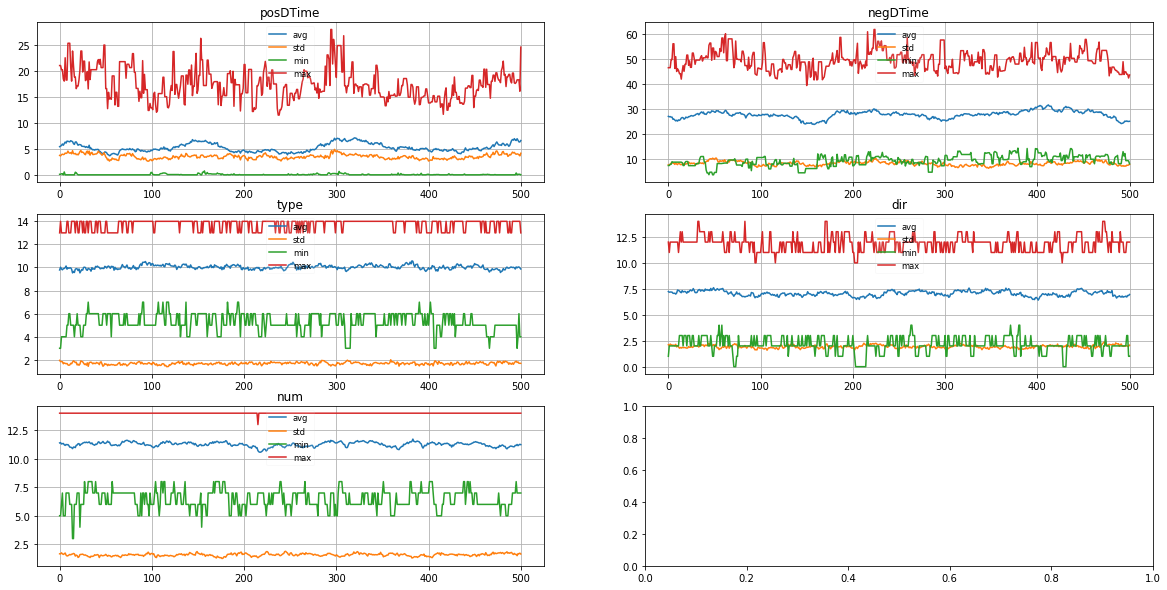

In [90]:
# to plot the log stats
fig, axes = plt.subplots(nrows=3, ncols=2)
plt.gcf().set_size_inches(20, 10)
for i,obj in enumerate(fitWei.keys()):
    for j,stype in enumerate(['avg','std','min','max']):
        dfp = df[df['ridx']==i]
        axes[i//2,i%2].plot(dfp['gen'], dfp[stype], label=stype)

    axes[i//2,i%2].set(title=obj)
    axes[i//2,i%2].grid()
    legend = axes[i//2,i%2].legend(loc='upper center', shadow=False, fontsize='small', framealpha=0.1)

# fig.savefig("05-logstats.png")